In [1]:
# run this line first
!pip3 install qiskit

The directory '/jupyteruser/41170271/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/41170271/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
    100% |████████████████████████████████| 3.0MB 13.8MB/s ta 0:00:01    13% |████▎                           | 399kB 18.8MB/s eta 0:00:01
    100% |████████████████████████████████| 23.4MB 1.3MB/s ta 0:00:011    50% |████████████████▎               | 11.9MB 30.8MB/s eta 0:00:01    57% |██████████████████▌             | 13.5MB 14.1MB/s eta 0:00:01    64% |████████████████████▉           | 15.2MB 18.4MB/s eta 0:00:01    68% |██████████████████████          | 16.1MB 18.0MB/s eta 0:00:01    75%

nbgrader 0.5.5 has requirement ipython<=6.2.1, but you'll have ipython 7.2.0 which is incompatible.
nbgrader 0.5.5 has requirement jupyter-console<=5.2.0, but you'll have jupyter-console 6.0.0 which is incompatible.
  Running setup.py install for psutil ... error
    Complete output from command /usr/bin/python3 -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-9508p4_4/psutil/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /tmp/pip-record-1o8f47ck/install-record.txt --single-version-externally-managed --compile:
    running install
    running build
    running build_py
    creating build
    creating build/lib.linux-x86_64-3.6
    creating build/lib.linux-x86_64-3.6/psutil
    copying psutil/_pslinux.py -> build/lib.linux-x86_64-3.6/psutil
    copying psutil/_psaix.py -> build/lib.linux-x86_64-3.6/psutil
    copying psutil/_pssunos.py -> build/lib.linux-x86_64-3.6/p

In [2]:
import os
import sys

from qiskit import (
    QuantumCircuit, QuantumRegister, ClassicalRegister, Aer,
    execute
)
from qiskit.tools.visualization import plot_histogram

assert sys.version_info >= (3,5), "Only Python 3.5 or greater supported."

# import state tomography functions
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from IPython.display import Image

%config InlineBackend.figure_format = 'svg' # Makes the images look nice

## Circuit errors, but no error codes

###  Without error codes, our computation is prone to error, like bit flips.

In [4]:
cq = QuantumRegister(1,'code\ qubit\ ')
mb = ClassicalRegister(1,'measurment\ bit\ ')

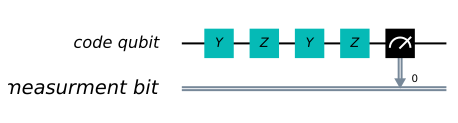

In [5]:
qc_intermediate = QuantumCircuit(cq, mb)
qc_intermediate.y(cq)
qc_intermediate.z(cq)
qc_intermediate.y(cq)
qc_intermediate.z(cq)


qc_measure = QuantumCircuit(cq, mb)
qc_measure.measure(cq[0], mb)

(qc_intermediate + qc_measure).draw(output='mpl')

In [10]:
def get_noise_model(error_scale):
    error_term = pauli_error([('X',error_scale), ('I', 1 - error_scale)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_term, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_term, ["y"])   # single qubit gate error is applied to y gates
    noise_model.add_all_qubit_quantum_error(error_term, ["z"])   # single qubit gate error is applied to z gates
    
    return noise_model

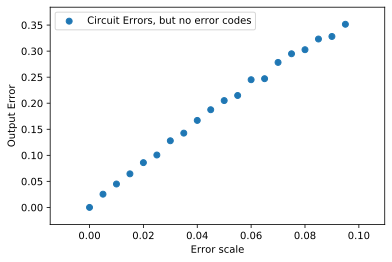

In [11]:
error_no_codes_scales = [i * 0.005 for i in range(20)]
error_no_codes_values = []
for error_scale in error_no_codes_scales:
    noise_model = get_noise_model(error_scale)
    counts = execute(qc_intermediate + qc_measure, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    if '0' not in counts:
        counts['0'] = 0
    if '1' not in counts:
        counts['1'] = 0
    error_no_codes_values.append(counts['1'] * 1. / (counts['1'] + counts['0']))
    
ax = plt.gca()
plt.xlabel('Error scale')
plt.ylabel('Output Error')
ax.scatter(error_no_codes_scales, error_no_codes_values, label="Circuit Errors, but no error codes")
plt.legend()
plt.show()
                              

## Circuit errors, repetition coding, but coding is errorless

### Adding repetition error can guard against bit flips and reduce the amount of error.

In [12]:
cq = QuantumRegister(3,'code\ qubit\ ')
mb = ClassicalRegister(1,'measurment\ bit\ ')

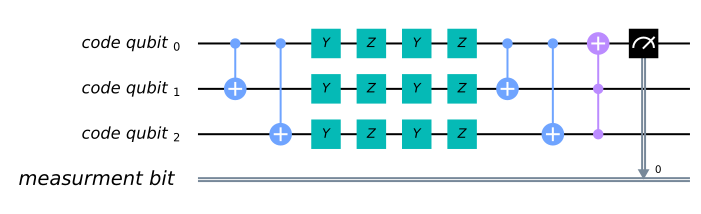

In [13]:
qc_encode = QuantumCircuit(cq, mb)
qc_encode.cx(cq[0],cq[1])
qc_encode.cx(cq[0],cq[2])

qc_intermediate = QuantumCircuit(cq, mb)
qc_intermediate.y(cq)
qc_intermediate.z(cq)
qc_intermediate.y(cq)
qc_intermediate.z(cq)

qc_decode = QuantumCircuit(cq, mb)
qc_decode.cx(cq[0],cq[1])
qc_decode.cx(cq[0],cq[2])
qc_decode.toffoli(cq[2],cq[1], cq[0])

qc_measure = QuantumCircuit(cq, mb)
qc_measure.measure(cq[0], mb)

(qc_encode+qc_intermediate+qc_decode+qc_measure).draw(output='mpl')

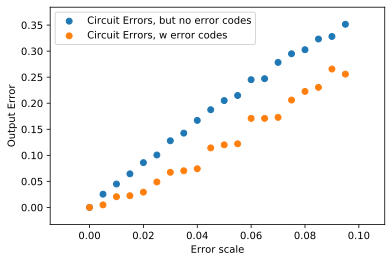

In [14]:
error_w_codes_scales = [i * 0.005 for i in range(20)]
error_w_codes_values = []
for error_scale in error_w_codes_scales:
    noise_model = get_noise_model(error_scale)
    counts = execute(qc_encode+qc_intermediate+qc_decode+qc_measure, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    if '0' not in counts:
        counts['0'] = 0
    if '1' not in counts:
        counts['1'] = 0
    error_w_codes_values.append(counts['1'] * 1. / (counts['1'] + counts['0']))
    
ax = plt.gca()
plt.xlabel('Error scale')
plt.ylabel('Output Error')
ax.scatter(error_no_codes_scales, error_no_codes_values, label="Circuit Errors, but no error codes")
ax.scatter(error_w_codes_scales, error_w_codes_values, label="Circuit Errors, w error codes")
plt.legend()
plt.show()

## Circuit errors, repetition coding, and coding errors

### But there can be error from the encoding and decoding itself. Depending on the magnitude, the cure can be worse than the disease.

In [10]:
def get_noise_model(error_scale, coding_error_scale):
    error_term = pauli_error([('X',error_scale), ('I', 1 - error_scale)])
    coding_error_term = pauli_error([('X',coding_error_scale), ('I', 1 - coding_error_scale)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_term, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_term, ["y"])   # single qubit gate error is applied to y gates
    noise_model.add_all_qubit_quantum_error(error_term, ["z"])   # single qubit gate error is applied to z gates
    noise_model.add_all_qubit_quantum_error(coding_error_term.tensor(coding_error_term), ["cx"])
    noise_model.add_all_qubit_quantum_error(coding_error_term.tensor(coding_error_term).tensor(coding_error_term), ["toffoli"])
    return noise_model


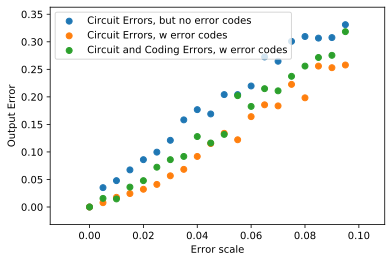

In [11]:
mid_error_w_codes_scales = [i * 0.005 for i in range(20)]
mid_error_w_codes_values = []
for error_scale in mid_error_w_codes_scales:
    noise_model = get_noise_model(error_scale, error_scale / 4)
    counts = execute(qc_encode+qc_intermediate+qc_decode+qc_measure, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    if '0' not in counts:
        counts['0'] = 0
    if '1' not in counts:
        counts['1'] = 0
    mid_error_w_codes_values.append(counts['1'] * 1. / (counts['1'] + counts['0']))
    
ax = plt.gca()
plt.xlabel('Error scale')
plt.ylabel('Output Error')
ax.scatter(error_no_codes_scales, error_no_codes_values, label="Circuit Errors, but no error codes")
ax.scatter(error_w_codes_scales, error_w_codes_values, label="Circuit Errors, w error codes")
ax.scatter(mid_error_w_codes_scales, mid_error_w_codes_values, label="Circuit and Coding Errors, w error codes")
plt.legend()
plt.show()

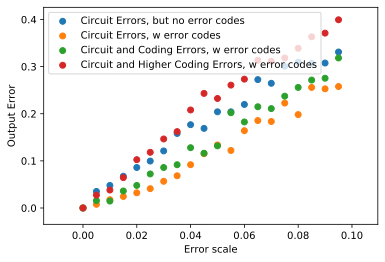

In [12]:
high_error_w_codes_scales = [i * 0.005 for i in range(20)]
high_error_w_codes_values = []
for error_scale in high_error_w_codes_scales:
    noise_model = get_noise_model(error_scale, error_scale)
    counts = execute(qc_encode+qc_intermediate+qc_decode+qc_measure, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    if '0' not in counts:
        counts['0'] = 0
    if '1' not in counts:
        counts['1'] = 0
    high_error_w_codes_values.append(counts['1'] * 1. / (counts['1'] + counts['0']))
    
ax = plt.gca()
plt.xlabel('Error scale')
plt.ylabel('Output Error')
ax.scatter(error_no_codes_scales, error_no_codes_values, label="Circuit Errors, but no error codes")
ax.scatter(error_w_codes_scales, error_w_codes_values, label="Circuit Errors, w error codes")
ax.scatter(mid_error_w_codes_scales, mid_error_w_codes_values, label="Circuit and Coding Errors, w error codes")
ax.scatter(high_error_w_codes_scales, high_error_w_codes_values, label="Circuit and Higher Coding Errors, w error codes")
plt.legend()
plt.show()

## Sign Flip

### Bit flips are not the only type of errors. We can have sign flips (aka phase flips).

In [13]:
cq = QuantumRegister(1,'code\ qubit\ ')
mb = ClassicalRegister(1,'measurment\ bit\ ')

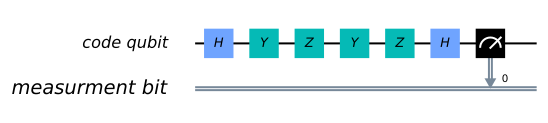

In [14]:
qc_intermediate = QuantumCircuit(cq, mb)
qc_intermediate.h(cq)
qc_intermediate.y(cq)
qc_intermediate.z(cq)
qc_intermediate.y(cq)
qc_intermediate.z(cq)
qc_intermediate.h(cq)


qc_measure = QuantumCircuit(cq, mb)
qc_measure.measure(cq[0], mb)

(qc_intermediate + qc_measure).draw(output='mpl')

In [15]:
def get_noise_model(error_scale):
    error_term = pauli_error([('Z',error_scale), ('I', 1 - error_scale)])
    measure_error_term = pauli_error([('X',error_scale), ('I', 1 - error_scale)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(measure_error_term, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_term, ["y"])   # single qubit gate error is applied to y gates
    noise_model.add_all_qubit_quantum_error(error_term, ["z"])   # single qubit gate error is applied to z gates
    
    return noise_model

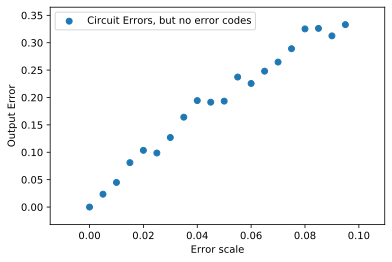

In [16]:
no_code_sign_flip_scales = [i * 0.005 for i in range(20)]
no_code_sign_flip_values = []
for error_scale in no_code_sign_flip_scales:
    noise_model = get_noise_model(error_scale)
    counts = execute(qc_intermediate + qc_measure, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    if '0' not in counts:
        counts['0'] = 0
    if '1' not in counts:
        counts['1'] = 0
    no_code_sign_flip_values.append(counts['1'] * 1. / (counts['1'] + counts['0']))
    
ax = plt.gca()
plt.xlabel('Error scale')
plt.ylabel('Output Error')
ax.scatter(no_code_sign_flip_scales, no_code_sign_flip_values, label="Circuit Errors, but no error codes")
plt.legend()
plt.show()
                              

## Repetition Coding With Sign Flips

### Repetition coding as above does not help with sign flips. More opportunities for errors can actually make it worse.

In [17]:
cq = QuantumRegister(3,'code\ qubit\ ')
mb = ClassicalRegister(1,'measurment\ bit\ ')

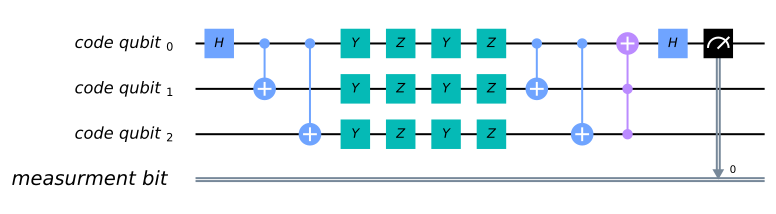

In [18]:
qc_encode = QuantumCircuit(cq, mb)
qc_encode.h(cq[0])
qc_encode.cx(cq[0],cq[1])
qc_encode.cx(cq[0],cq[2])

qc_intermediate = QuantumCircuit(cq, mb)
qc_intermediate.y(cq)
qc_intermediate.z(cq)
qc_intermediate.y(cq)
qc_intermediate.z(cq)

qc_decode = QuantumCircuit(cq, mb)
qc_decode.cx(cq[0],cq[1])
qc_decode.cx(cq[0],cq[2])
qc_decode.toffoli(cq[2],cq[1], cq[0])

qc_measure = QuantumCircuit(cq, mb)
qc_measure.h(cq[0])
qc_measure.measure(cq[0], mb)

(qc_encode+qc_intermediate+qc_decode+qc_measure).draw(output='mpl')

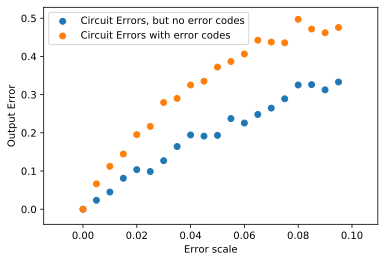

In [19]:
code_sign_flip_scales = [i * 0.005 for i in range(20)]
code_sign_flip_values = []
for error_scale in code_sign_flip_scales:
    noise_model = get_noise_model(error_scale)
    counts = execute(qc_encode+qc_intermediate+qc_decode+qc_measure, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    if '0' not in counts:
        counts['0'] = 0
    if '1' not in counts:
        counts['1'] = 0
    code_sign_flip_values.append(counts['1'] * 1. / (counts['1'] + counts['0']))
    
ax = plt.gca()
plt.xlabel('Error scale')
plt.ylabel('Output Error')
ax.scatter(no_code_sign_flip_scales, no_code_sign_flip_values, label="Circuit Errors, but no error codes")
ax.scatter(code_sign_flip_scales, code_sign_flip_values, label="Circuit Errors with error codes")
plt.legend()
plt.show()

## Modified Repetition Coding With Sign Flips

### Modify the repetition coding scheme to have hadamards at the end of encoding and the beginning of decoding. This scheme is able to reduce errors from sign flips.

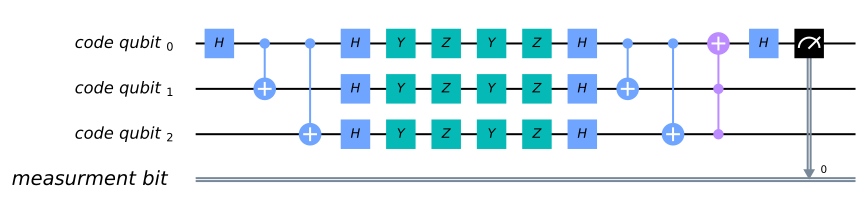

In [20]:
qc_encode = QuantumCircuit(cq, mb)
qc_encode.h(cq[0])
qc_encode.cx(cq[0],cq[1])
qc_encode.cx(cq[0],cq[2])
qc_encode.h(cq)

qc_intermediate = QuantumCircuit(cq, mb)
qc_intermediate.y(cq)
qc_intermediate.z(cq)
qc_intermediate.y(cq)
qc_intermediate.z(cq)

qc_decode = QuantumCircuit(cq, mb)
qc_decode.h(cq)
qc_decode.cx(cq[0],cq[1])
qc_decode.cx(cq[0],cq[2])
qc_decode.toffoli(cq[2],cq[1], cq[0])

qc_measure = QuantumCircuit(cq, mb)
qc_measure.h(cq[0])
qc_measure.measure(cq[0], mb)

(qc_encode+qc_intermediate+qc_decode+qc_measure).draw(output='mpl')

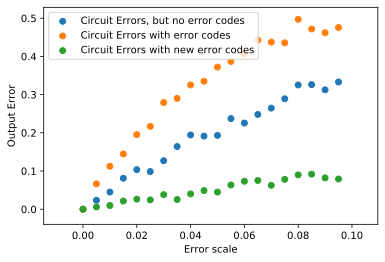

In [21]:
new_code_sign_flip_scales = [i * 0.005 for i in range(20)]
new_code_sign_flip_values = []
for error_scale in new_code_sign_flip_scales:
    noise_model = get_noise_model(error_scale)
    counts = execute(qc_encode+qc_intermediate+qc_decode+qc_measure, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    if '0' not in counts:
        counts['0'] = 0
    if '1' not in counts:
        counts['1'] = 0
    new_code_sign_flip_values.append(counts['1'] * 1. / (counts['1'] + counts['0']))
    
ax = plt.gca()
plt.xlabel('Error scale')
plt.ylabel('Output Error')
ax.scatter(no_code_sign_flip_scales, no_code_sign_flip_values, label="Circuit Errors, but no error codes")
ax.scatter(code_sign_flip_scales, code_sign_flip_values, label="Circuit Errors with error codes")
ax.scatter(new_code_sign_flip_scales, new_code_sign_flip_values, label="Circuit Errors with new error codes")
plt.legend()
plt.show()

## Shor Code

### Various other coding schemes exist. The Shor code is one that is resilient to any arbitrary single qubit error, not just bit flip or sign flips.

In [18]:
cq = QuantumRegister(9,'code\ qubit\ ')

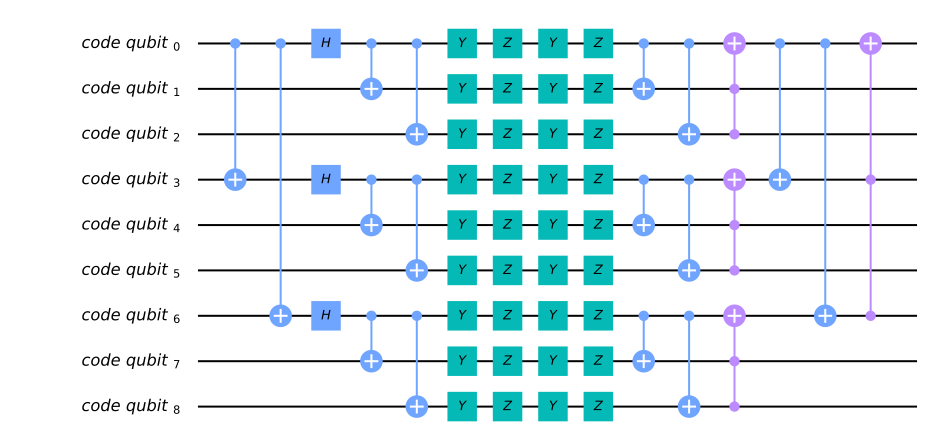

In [19]:
qc_encode = QuantumCircuit(cq)
qc_encode.cx(cq[0],cq[3])
qc_encode.cx(cq[0],cq[6])
qc_encode.h(cq[0])
qc_encode.h(cq[3])
qc_encode.h(cq[6])
qc_encode.cx(cq[0],cq[1])
qc_encode.cx(cq[0],cq[2])
qc_encode.cx(cq[3],cq[4])
qc_encode.cx(cq[3],cq[5])
qc_encode.cx(cq[6],cq[7])
qc_encode.cx(cq[6],cq[8])


qc_intermediate = QuantumCircuit(cq)
qc_intermediate.y(cq)
qc_intermediate.z(cq)
qc_intermediate.y(cq)
qc_intermediate.z(cq)

qc_decode = QuantumCircuit(cq)
qc_decode.cx(cq[0],cq[1])
qc_decode.cx(cq[0],cq[2])
qc_decode.toffoli(cq[2],cq[1], cq[0])
qc_decode.cx(cq[3],cq[4])
qc_decode.cx(cq[3],cq[5])
qc_decode.toffoli(cq[5],cq[4], cq[3])
qc_decode.cx(cq[6],cq[7])
qc_decode.cx(cq[6],cq[8])
qc_decode.toffoli(cq[8],cq[7], cq[6])
qc_decode.cx(cq[0],cq[3])
qc_decode.cx(cq[0],cq[6])
qc_decode.toffoli(cq[6],cq[3], cq[0])

(qc_encode+qc_intermediate+qc_decode).draw(output='mpl')